# Per-Layer Energy Profiling for DistilBERT
## ESE 5390 Final Project: Layer-wise Energy Analysis

This notebook analyzes the energy consumption of each layer in DistilBERT (FP32 baseline).

**Goal**: Identify which layers consume the most energy to guide selective quantization strategies.

**Approach**:
1. Use PyTorch hooks to measure execution time per layer
2. Monitor GPU power during inference
3. Compute energy consumption per layer
4. Visualize energy hotspots in the model

## 1. Setup and Imports

In [7]:
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import json
import time
import subprocess
import threading
from pathlib import Path
from typing import Dict, List, Tuple
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA version: 12.4


## 2. Load Dataset

In [8]:
# Auto-detect dataset path
import os

cwd = os.getcwd()
print(f"Current working directory: {cwd}")

# Check if we need to clone the repo (for Kaggle)
repo_path = Path(cwd) / "energy_aware_quantization"
if not repo_path.exists() and "kaggle" in cwd.lower():
    print("\n⚙️  Cloning repository (Kaggle environment detected)...")
    import subprocess
    result = subprocess.run(
        ["git", "clone", "https://github.com/krishkc5/energy_aware_quantization.git"],
        cwd=cwd,
        capture_output=True,
        text=True
    )
    if result.returncode == 0:
        print("✓ Repository cloned successfully")
    else:
        print(f"Warning: Could not clone repository: {result.stderr}")

possible_paths = [
    Path(cwd) / "energy_aware_quantization" / "datasets" / "tokenized_data",  # Kaggle after clone
    Path(cwd) / ".." / "datasets" / "tokenized_data",  # From notebooks/
    Path(cwd) / "datasets" / "tokenized_data",          # From repo root
    Path(cwd) / ".." / ".." / "datasets" / "tokenized_data",  # From deeper nesting
]

dataset_path = None
for path in possible_paths:
    abs_path = path.resolve()
    print(f"Trying: {abs_path}")
    if abs_path.exists() and (abs_path / "input_ids.pt").exists():
        dataset_path = str(abs_path)
        break

if dataset_path is None:
    current = Path(cwd)
    for _ in range(5):
        test_path = current / "datasets" / "tokenized_data"
        print(f"Trying: {test_path.resolve()}")
        if test_path.exists() and (test_path / "input_ids.pt").exists():
            dataset_path = str(test_path.resolve())
            break
        current = current.parent

if dataset_path is None:
    raise FileNotFoundError(
        f"Could not find dataset. Tried:\n" + 
        "\n".join([f"  - {p.resolve()}" for p in possible_paths]) +
        f"\n\nCurrent directory: {cwd}\n" +
        "Please ensure the dataset exists or the repository is cloned."
    )

print(f"\n✓ Found dataset at: {dataset_path}")

# Load dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = Path(dataset_path)

input_ids = torch.load(dataset_path / "input_ids.pt", map_location=device)
attention_mask = torch.load(dataset_path / "attention_mask.pt", map_location=device)
labels = torch.load(dataset_path / "labels.pt", map_location=device)

print(f"\n✓ Loaded dataset:")
print(f"  - Samples: {input_ids.shape[0]}")
print(f"  - Sequence length: {input_ids.shape[1]}")
print(f"  - Device: {input_ids.device}")

Current working directory: /kaggle/working
Trying: /kaggle/working/energy_aware_quantization/datasets/tokenized_data

✓ Found dataset at: /kaggle/working/energy_aware_quantization/datasets/tokenized_data

✓ Loaded dataset:
  - Samples: 50
  - Sequence length: 128
  - Device: cuda:0


## 3. Load DistilBERT Model

In [9]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

print(f"Loading {model_name}...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    torch_dtype=torch.float32
)
model = model.to(device)
model.eval()

print(f"\n✓ Model loaded")
print(f"  - Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Device: {next(model.parameters()).device}")

# Print model architecture
print(f"\n📋 Model Architecture:")
for name, module in model.named_children():
    print(f"  - {name}: {module.__class__.__name__}")

Loading distilbert-base-uncased-finetuned-sst-2-english...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

2025-12-03 09:20:54.008752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764753654.205834      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764753654.269919      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


✓ Model loaded
  - Parameters: 66,955,010
  - Device: cuda:0

📋 Model Architecture:
  - distilbert: DistilBertModel
  - pre_classifier: Linear
  - classifier: Linear
  - dropout: Dropout


## 4. Layer Profiler with Timing Hooks

We'll use PyTorch forward hooks to measure execution time for each layer.

In [10]:
class LayerProfiler:
    """
    Profile execution time of each layer using forward hooks.
    """
    
    def __init__(self, model: nn.Module, device: str = "cuda"):
        self.model = model
        self.device = device
        self.hooks = []
        self.layer_times = defaultdict(list)
        self.layer_names = []
        self.current_forward_start = None
        
        # Register hooks for all named modules
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward pre/post hooks on all layers."""
        
        def make_pre_hook(name):
            def pre_hook(module, input):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_start"].append(time.perf_counter())
            return pre_hook
        
        def make_post_hook(name):
            def post_hook(module, input, output):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_end"].append(time.perf_counter())
            return post_hook
        
        # Register hooks on important layers
        for name, module in self.model.named_modules():
            # Skip container modules and focus on actual computation layers
            if len(list(module.children())) == 0:  # Leaf modules only
                if isinstance(module, (nn.Linear, nn.LayerNorm, nn.Dropout, nn.GELU, nn.Embedding)):
                    self.layer_names.append(name)
                    hook_pre = module.register_forward_pre_hook(make_pre_hook(name))
                    hook_post = module.register_forward_hook(make_post_hook(name))
                    self.hooks.append(hook_pre)
                    self.hooks.append(hook_post)
        
        print(f"✓ Registered hooks on {len(self.layer_names)} layers")
    
    def reset(self):
        """Reset timing statistics."""
        self.layer_times.clear()
    
    def remove_hooks(self):
        """Remove all hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
    
    def get_layer_times(self) -> Dict[str, float]:
        """
        Compute average execution time per layer.
        
        Returns:
            Dictionary mapping layer name to average time in seconds
        """
        layer_avg_times = {}
        
        for name in self.layer_names:
            start_times = self.layer_times.get(name + "_start", [])
            end_times = self.layer_times.get(name + "_end", [])
            
            if len(start_times) == len(end_times) and len(start_times) > 0:
                durations = [end - start for start, end in zip(start_times, end_times)]
                layer_avg_times[name] = np.mean(durations)
        
        return layer_avg_times
    
    def get_layer_stats(self) -> pd.DataFrame:
        """
        Get detailed statistics for each layer.
        
        Returns:
            DataFrame with layer statistics
        """
        stats = []
        
        for name in self.layer_names:
            start_times = self.layer_times.get(name + "_start", [])
            end_times = self.layer_times.get(name + "_end", [])
            
            if len(start_times) == len(end_times) and len(start_times) > 0:
                durations = [end - start for start, end in zip(start_times, end_times)]
                
                stats.append({
                    "layer_name": name,
                    "mean_time_ms": np.mean(durations) * 1000,
                    "std_time_ms": np.std(durations) * 1000,
                    "min_time_ms": np.min(durations) * 1000,
                    "max_time_ms": np.max(durations) * 1000,
                    "total_time_s": np.sum(durations),
                    "num_calls": len(durations)
                })
        
        df = pd.DataFrame(stats)
        
        # Add percentage of total time
        if len(df) > 0:
            total_time = df["total_time_s"].sum()
            df["percent_total"] = (df["total_time_s"] / total_time) * 100
        
        return df.sort_values("total_time_s", ascending=False)


# Create profiler
profiler = LayerProfiler(model, device=device)

✓ Registered hooks on 67 layers


## 5. Power Monitor

Simple power monitoring using nvidia-smi.

In [11]:
class SimplePowerMonitor:
    """
    Simple power monitor using nvidia-smi.
    """
    
    def __init__(self, interval_ms: int = 50, gpu_id: int = 0):
        self.interval_ms = interval_ms
        self.gpu_id = gpu_id
        self.samples = []
        self.is_running = False
        self._thread = None
        self._lock = threading.Lock()
    
    def _poll(self):
        """Poll nvidia-smi for power readings."""
        interval_sec = self.interval_ms / 1000.0
        
        while self.is_running:
            try:
                result = subprocess.run(
                    ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits", f"--id={self.gpu_id}"],
                    capture_output=True, text=True, timeout=2
                )
                if result.returncode == 0:
                    power = float(result.stdout.strip())
                    with self._lock:
                        self.samples.append((time.perf_counter(), power))
            except:
                pass
            time.sleep(interval_sec)
    
    def start(self):
        """Start monitoring."""
        with self._lock:
            self.samples = []
            self.is_running = True
        
        self._thread = threading.Thread(target=self._poll, daemon=True)
        self._thread.start()
    
    def stop(self):
        """Stop monitoring."""
        self.is_running = False
        if self._thread:
            self._thread.join(timeout=2)
    
    def get_samples(self) -> List[Tuple[float, float]]:
        """Get (timestamp, power) samples."""
        with self._lock:
            return self.samples.copy()
    
    def get_mean_power(self) -> float:
        """Get mean power in Watts."""
        samples = self.get_samples()
        if len(samples) == 0:
            return 0.0
        return np.mean([p for _, p in samples])


power_monitor = SimplePowerMonitor(interval_ms=50)
print("✓ Power monitor initialized")

✓ Power monitor initialized


## 6. Run Profiling Inference

Run inference with layer profiling and power monitoring.

In [12]:
# Warmup
print("Warming up GPU...")
with torch.no_grad():
    for _ in range(50):
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
if device == "cuda":
    torch.cuda.synchronize()
print("✓ Warmup complete\n")

# Reset profiler
profiler.reset()

# Run profiling with power monitoring
num_iters = 100
print(f"Running {num_iters} profiling iterations...")

power_monitor.start()
time.sleep(0.3)  # Let power monitor stabilize

if device == "cuda":
    torch.cuda.synchronize()

start_time = time.perf_counter()

with torch.no_grad():
    for i in range(num_iters):
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
        
        if (i + 1) % 20 == 0:
            print(f"  Progress: {i+1}/{num_iters}", end='\r')

if device == "cuda":
    torch.cuda.synchronize()

end_time = time.perf_counter()

time.sleep(0.3)  # Capture trailing power samples
power_monitor.stop()

total_time = end_time - start_time
mean_power = power_monitor.get_mean_power()

print(f"\n\n✓ Profiling complete")
print(f"  - Total time: {total_time:.3f}s")
print(f"  - Mean power: {mean_power:.2f}W")
print(f"  - Total energy: {mean_power * total_time:.3f}J")
print(f"  - Power samples: {len(power_monitor.get_samples())}")

Warming up GPU...
✓ Warmup complete

Running 100 profiling iterations...
  Progress: 100/100

✓ Profiling complete
  - Total time: 9.357s
  - Mean power: 206.23W
  - Total energy: 1929.712J
  - Power samples: 125


## 7. Analyze Per-Layer Timing

In [13]:
# Get layer statistics
layer_stats = profiler.get_layer_stats()

print("\n" + "="*80)
print("PER-LAYER TIMING STATISTICS (Top 20)")
print("="*80)
print(layer_stats.head(20).to_string(index=False))
print("="*80)

# Save to CSV
output_dir = Path("../results")
output_dir.mkdir(parents=True, exist_ok=True)
layer_stats.to_csv(output_dir / "per_layer_timing_fp32.csv", index=False)
print(f"\n✓ Saved layer timing to: {output_dir / 'per_layer_timing_fp32.csv'}")


PER-LAYER TIMING STATISTICS (Top 20)
                                      layer_name  mean_time_ms  std_time_ms  min_time_ms  max_time_ms  total_time_s  num_calls  percent_total
         distilbert.transformer.layer.5.ffn.lin2      4.316115     0.056914     4.186384     4.404639      0.431612        100       5.236094
         distilbert.transformer.layer.4.ffn.lin2      4.314395     0.052508     4.176733     4.411381      0.431439        100       5.234007
         distilbert.transformer.layer.1.ffn.lin2      4.309896     0.056925     4.179869     4.386233      0.430990        100       5.228550
         distilbert.transformer.layer.2.ffn.lin2      4.308857     0.057050     4.186242     4.386785      0.430886        100       5.227290
         distilbert.transformer.layer.0.ffn.lin2      4.307235     0.056680     4.183483     4.397751      0.430723        100       5.225321
         distilbert.transformer.layer.3.ffn.lin2      4.301793     0.063639     4.177854     4.395545      0.4

## 8. Compute Per-Layer Energy Consumption

Estimate energy per layer using:
- Layer execution time (from profiling)
- Mean GPU power (from power monitor)

**Energy per layer = (Layer time / Total time) × Total energy**

In [14]:
# Compute per-layer energy
total_energy = mean_power * total_time  # Joules
total_measured_time = layer_stats["total_time_s"].sum()

layer_stats["energy_j"] = (layer_stats["total_time_s"] / total_measured_time) * total_energy
layer_stats["energy_mj"] = layer_stats["energy_j"] * 1000
layer_stats["energy_per_call_mj"] = layer_stats["energy_mj"] / layer_stats["num_calls"]

# Sort by energy consumption
layer_stats = layer_stats.sort_values("energy_j", ascending=False)

print("\n" + "="*100)
print("PER-LAYER ENERGY CONSUMPTION (Top 20)")
print("="*100)
print(layer_stats[["layer_name", "mean_time_ms", "energy_mj", "energy_per_call_mj", "percent_total"]].head(20).to_string(index=False))
print("="*100)

# Save to CSV
layer_stats.to_csv(output_dir / "per_layer_energy_fp32.csv", index=False)
print(f"\n✓ Saved layer energy to: {output_dir / 'per_layer_energy_fp32.csv'}")


PER-LAYER ENERGY CONSUMPTION (Top 20)
                                      layer_name  mean_time_ms     energy_mj  energy_per_call_mj  percent_total
         distilbert.transformer.layer.5.ffn.lin2      4.316115 101041.552564         1010.415526       5.236094
         distilbert.transformer.layer.4.ffn.lin2      4.314395 101001.276077         1010.012761       5.234007
         distilbert.transformer.layer.1.ffn.lin2      4.309896 100895.970222         1008.959702       5.228550
         distilbert.transformer.layer.2.ffn.lin2      4.308857 100871.650196         1008.716502       5.227290
         distilbert.transformer.layer.0.ffn.lin2      4.307235 100833.663471         1008.336635       5.225321
         distilbert.transformer.layer.3.ffn.lin2      4.301793 100706.274913         1007.062749       5.218720
         distilbert.transformer.layer.0.ffn.lin1      4.284308 100296.935029         1002.969350       5.197507
         distilbert.transformer.layer.1.ffn.lin1      4.281791 10

## 9. Group Energy by Layer Type

In [15]:
# Extract layer type from name
def get_layer_type(name: str) -> str:
    """Extract layer type from full layer name."""
    if "attention.q_lin" in name or "attention.k_lin" in name or "attention.v_lin" in name:
        return "Attention Projection"
    elif "attention.out_lin" in name:
        return "Attention Output"
    elif "ffn.lin1" in name:
        return "FFN Layer 1"
    elif "ffn.lin2" in name:
        return "FFN Layer 2"
    elif "sa_layer_norm" in name or "output_layer_norm" in name:
        return "LayerNorm"
    elif "embeddings" in name:
        return "Embeddings"
    elif "pre_classifier" in name or "classifier" in name:
        return "Classifier"
    elif "dropout" in name:
        return "Dropout"
    else:
        return "Other"

layer_stats["layer_type"] = layer_stats["layer_name"].apply(get_layer_type)

# Group by layer type
type_energy = layer_stats.groupby("layer_type").agg({
    "energy_j": "sum",
    "energy_mj": "sum",
    "total_time_s": "sum",
    "layer_name": "count"
}).rename(columns={"layer_name": "num_layers"})

type_energy["percent_energy"] = (type_energy["energy_j"] / type_energy["energy_j"].sum()) * 100
type_energy = type_energy.sort_values("energy_j", ascending=False)

print("\n" + "="*80)
print("ENERGY CONSUMPTION BY LAYER TYPE")
print("="*80)
print(type_energy.to_string())
print("="*80)

# Save to CSV
type_energy.to_csv(output_dir / "energy_by_layer_type_fp32.csv")
print(f"\n✓ Saved grouped energy to: {output_dir / 'energy_by_layer_type_fp32.csv'}")


ENERGY CONSUMPTION BY LAYER TYPE
                        energy_j      energy_mj  total_time_s  num_layers  percent_energy
layer_type                                                                               
FFN Layer 2           605.350387  605350.387442      2.585829           6       31.369981
FFN Layer 1           601.216448  601216.447813      2.568171           6       31.155756
Attention Projection  491.185577  491185.576996      2.098160          18       25.453824
Attention Output      164.179330  164179.329953      0.701312           6        8.507969
LayerNorm              46.485403   46485.402800      0.198568          12        2.408929
Embeddings             12.100528   12100.528077      0.051689           4        0.627064
Dropout                 4.972447    4972.447220      0.021240           7        0.257678
Classifier              4.222167    4222.167435      0.018036           2        0.218798

✓ Saved grouped energy to: ../results/energy_by_layer_type_fp32.c

## 10. Visualizations


✓ Saved plots to: ../results/per_layer_energy_analysis_fp32.png


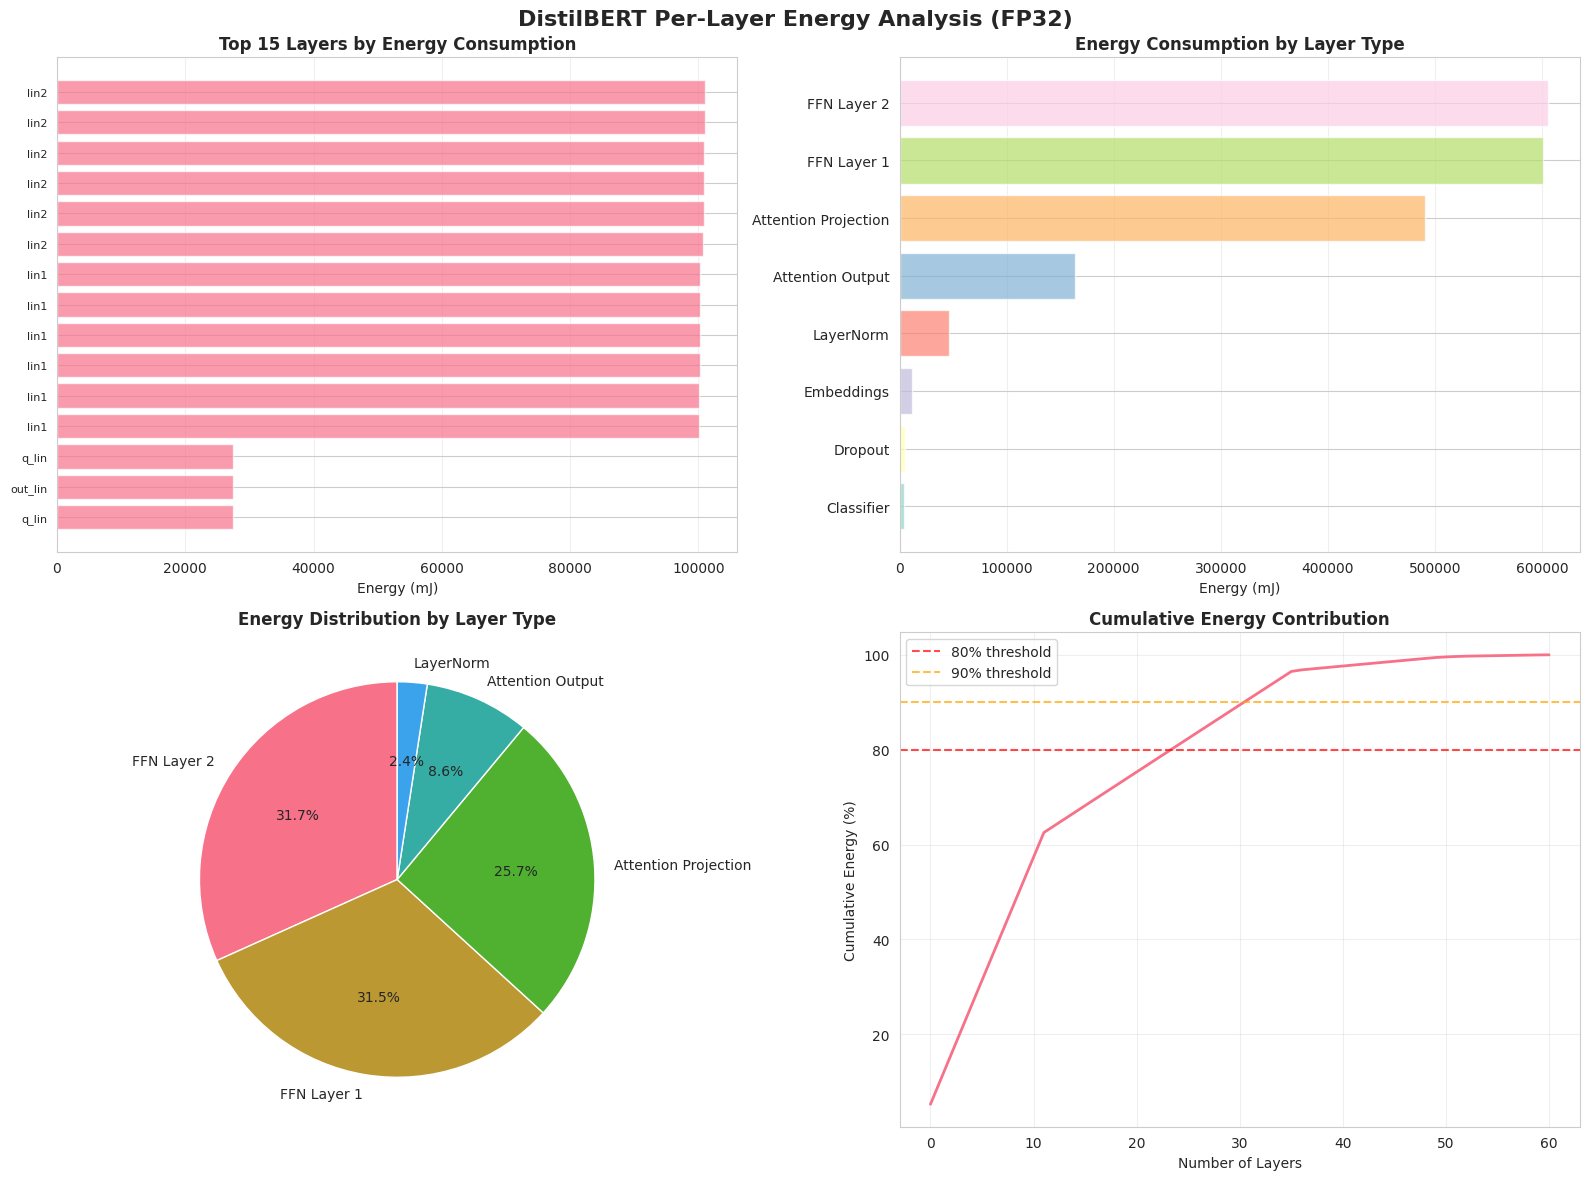

In [16]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("DistilBERT Per-Layer Energy Analysis (FP32)", fontsize=16, fontweight='bold')

# 1. Top 15 layers by energy
ax = axes[0, 0]
top_layers = layer_stats.head(15)
y_pos = range(len(top_layers))
ax.barh(y_pos, top_layers["energy_mj"], alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels([name.split('.')[-1] if len(name.split('.')) > 1 else name for name in top_layers["layer_name"]], fontsize=8)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Top 15 Layers by Energy Consumption", fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# 2. Energy by layer type
ax = axes[0, 1]
type_energy_sorted = type_energy.sort_values("energy_mj", ascending=True)
y_pos = range(len(type_energy_sorted))
colors = plt.cm.Set3(range(len(type_energy_sorted)))
ax.barh(y_pos, type_energy_sorted["energy_mj"], alpha=0.7, color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(type_energy_sorted.index, fontsize=10)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Energy Consumption by Layer Type", fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 3. Pie chart of energy distribution
ax = axes[1, 0]
type_energy_pie = type_energy[type_energy["percent_energy"] > 1.0]  # Show only >1%
ax.pie(type_energy_pie["percent_energy"], labels=type_energy_pie.index, autopct='%1.1f%%', startangle=90)
ax.set_title("Energy Distribution by Layer Type", fontsize=12, fontweight='bold')

# 4. Cumulative energy contribution
ax = axes[1, 1]
cumulative = layer_stats["energy_mj"].cumsum() / layer_stats["energy_mj"].sum() * 100
ax.plot(range(len(cumulative)), cumulative, linewidth=2)
ax.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
ax.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax.set_xlabel("Number of Layers", fontsize=10)
ax.set_ylabel("Cumulative Energy (%)", fontsize=10)
ax.set_title("Cumulative Energy Contribution", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plot_path = output_dir / "per_layer_energy_analysis_fp32.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved plots to: {plot_path}")
plt.show()

## 11. Key Insights

Identify the most energy-hungry layers for targeted quantization.

In [17]:
# Find how many layers account for 80% of energy
cumulative_energy = layer_stats["energy_j"].cumsum() / layer_stats["energy_j"].sum()
layers_for_80_pct = (cumulative_energy <= 0.80).sum()
layers_for_90_pct = (cumulative_energy <= 0.90).sum()

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print(f"\n📊 Energy Distribution:")
print(f"  - Total layers profiled: {len(layer_stats)}")
print(f"  - Layers accounting for 80% of energy: {layers_for_80_pct} ({layers_for_80_pct/len(layer_stats)*100:.1f}%)")
print(f"  - Layers accounting for 90% of energy: {layers_for_90_pct} ({layers_for_90_pct/len(layer_stats)*100:.1f}%)")

print(f"\n🔥 Top Energy Consumers:")
top_3 = layer_stats.head(3)
for i, row in top_3.iterrows():
    print(f"  {row['layer_name']}:")
    print(f"    - Energy: {row['energy_mj']:.2f} mJ ({row['percent_total']:.1f}% of total)")
    print(f"    - Avg time: {row['mean_time_ms']:.3f} ms per call")

print(f"\n🎯 Quantization Strategy Recommendations:")
print(f"  1. Prioritize quantizing: {type_energy.head(3).index.tolist()}")
print(f"  2. These layer types account for {type_energy.head(3)['percent_energy'].sum():.1f}% of total energy")
print(f"  3. Consider keeping embeddings and LayerNorm in higher precision")

print("\n" + "="*80)


KEY INSIGHTS

📊 Energy Distribution:
  - Total layers profiled: 61
  - Layers accounting for 80% of energy: 24 (39.3%)
  - Layers accounting for 90% of energy: 31 (50.8%)

🔥 Top Energy Consumers:
  distilbert.transformer.layer.5.ffn.lin2:
    - Energy: 101041.55 mJ (5.2% of total)
    - Avg time: 4.316 ms per call
  distilbert.transformer.layer.4.ffn.lin2:
    - Energy: 101001.28 mJ (5.2% of total)
    - Avg time: 4.314 ms per call
  distilbert.transformer.layer.1.ffn.lin2:
    - Energy: 100895.97 mJ (5.2% of total)
    - Avg time: 4.310 ms per call

🎯 Quantization Strategy Recommendations:
  1. Prioritize quantizing: ['FFN Layer 2', 'FFN Layer 1', 'Attention Projection']
  2. These layer types account for 88.0% of total energy
  3. Consider keeping embeddings and LayerNorm in higher precision



## 12. Export Summary Report

In [18]:
# Create summary report
summary_report = {
    "model_name": model_name,
    "precision": "fp32",
    "num_profiling_iterations": num_iters,
    "total_time_s": float(total_time),
    "mean_power_w": float(mean_power),
    "total_energy_j": float(total_energy),
    "num_layers_profiled": len(layer_stats),
    "layers_for_80pct_energy": int(layers_for_80_pct),
    "layers_for_90pct_energy": int(layers_for_90_pct),
    "top_energy_layer": layer_stats.iloc[0]["layer_name"],
    "top_energy_layer_mj": float(layer_stats.iloc[0]["energy_mj"]),
    "top_energy_layer_percent": float(layer_stats.iloc[0]["percent_total"]),
    "energy_by_type": type_energy.to_dict(),
}

# Save as JSON
report_path = output_dir / "per_layer_energy_summary_fp32.json"
with open(report_path, 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"✓ Saved summary report to: {report_path}")

# Clean up
profiler.remove_hooks()
print("\n✓ Profiling complete and hooks removed")

✓ Saved summary report to: ../results/per_layer_energy_summary_fp32.json

✓ Profiling complete and hooks removed


## Summary

This notebook provides:
1. **Per-layer timing** using PyTorch forward hooks
2. **Per-layer energy estimates** based on timing and power monitoring
3. **Energy breakdown by layer type** (Attention, FFN, LayerNorm, etc.)
4. **Visualizations** showing energy hotspots
5. **Quantization recommendations** based on energy analysis

### Key Takeaways:
- Identifies which layers consume the most energy
- Shows cumulative energy contribution
- Guides selective quantization strategies
- Helps prioritize optimization efforts